## Working with Parameter Sets
COPASI supports storing multiple parameter sets for a model. This tutorial describes how to work with them. We start by loading the brusselator example model: 

In [1]:
from basico import *

In [2]:
brusselator = load_example('brus')

Currently we dont have any parameter sets in this file: 

In [3]:
get_parameter_sets()

[]

so lets create a new parameter set from the current state:

In [4]:
add_parameter_set('InitialState')

### Looking at parameter sets

now let us look at it using the `get_parameter_sets` method. If no name is specified, `get_parameter_sets` returns all parameter sets in the file as a list of dictionaries, in each one you will find the following keys: 

* `name`: the name of the parameter set
* `description`: notes if any
* `Initial Time`: a dictionary with the initial time of the model
* `Initial Compartment Sizes`: a dictionary with the compartment sizes of all compartments
* `Initial Species Values`: a dictionary with the initial concentration of all species
* `Initial Global Quantities`: a dictionary with the initial values of all global parameters
* `Kinetic Parameters`: a dictionary of all local reaction parameters

`get_parameter_sets` takes 3 arguments: 

* `name`: the name of the parameter set to return (can be a substring, to return multiple)
* `exact`: whether the name has to be precisely matched
* `values_only`: if true, only the initial values will be returned, otherwise also the type of model parameter

so you will see either: 

In [5]:
get_parameter_sets(values_only=True)

[{'name': 'InitialState',
  'description': '',
  'Initial Time': {'The Brusselator': 0.0},
  'Initial Compartment Sizes': {'compartment': 1.0},
  'Initial Species Values': {'X': 2.9999959316797846,
   'Y': 2.9999959316797846,
   'A': 0.49999987545958524,
   'B': 2.9999959316797846,
   'D': 0.0,
   'E': 0.0},
  'Initial Global Quantities': {},
  'Kinetic Parameters': {'R1': {'k1': 1.0},
   'R2': {'k1': 1.0},
   'R3': {'k1': 1.0},
   'R4': {'k1': 1.0}}}]

or the much more verbose variant (I'll restrict it here to just one of the species to avoid clutter): 

In [6]:
get_parameter_sets()[0]['Initial Species Values']['X']

{'concentration': 2.9999959316797846,
 'particle_number': 1.80664e+21,
 'parameter_type': 'species',
 'simulation_type': 'reactions'}

### Creating / Modifying Parameter sets
As we saw above, we can add a new parameter set using `add_parameter_set` with only a name parameter, you can also specify the parameter set, by providing the dictionary as it was returned above. It does not have to be complete, you can can also create a partial one, containing only those values you want to specify. 

**NOTE**: when specifying concentrations, you will also have to specify the initial compartment volume for those species. 

In [7]:
add_parameter_set('Partial', {
         'Initial Compartment Sizes': {'compartment': 1},
         'Initial Species Values': {'X': 3, 'Y': 1}})

In [8]:
get_parameter_sets('Partial', values_only=True)[0]

{'name': 'Partial',
 'description': '',
 'Initial Time': {},
 'Initial Compartment Sizes': {'compartment': 1.0},
 'Initial Species Values': {'X': 3.0, 'Y': 1.0},
 'Initial Global Quantities': {},
 'Kinetic Parameters': {}}

to change certain values in a parameter set, you can use the `set_parameter_set`, this will set all the values specified, and by default leave all entries not specified at their old values. You'd use the argument `remove_others=True`, to remove all entries not specified. For example, let me set the initial concentration of `Y` in the Partial parameter set to 3: 

In [9]:
set_parameter_set('Partial', param_set_dict={'Initial Species Values': {'Y': 3}}, remove_others=False)
get_parameter_sets('Partial', values_only=True)[0]['Initial Species Values']

{'X': 3.0, 'Y': 3.0}

To change the current model state, to use the values specified in a certain parameter set, you'd use the function `apply_parameter_set`: 

In [10]:
apply_parameter_set('Partial')
get_species()[['initial_concentration']]

,initial_concentration
name,
X,3.000000
Y,3.000000
A,0.500000
B,2.999996
D,0.000000
E,0.000000


If you wanted to update a parameter set, with all the values from the current model state, you can use `update_parameter_set`. Lets use that here, to update the `InitialState` parameter set from above, to contain the updated concentrations: 

In [11]:
update_parameter_set('InitialState')
get_parameter_sets('InitialState', values_only=True)[0]['Initial Species Values']

{'X': 3.0,
 'Y': 3.0,
 'A': 0.49999987545958524,
 'B': 2.9999959316797846,
 'D': 0.0,
 'E': 0.0}

### Removing parameter sets
The `remove_parameter_sets` function can be used to remove parameter sets if no argument is specified, all paraemter sets will be removed, otherwise the once matching the given name. Here i just want to remove the partial one defined above: 

In [12]:
remove_parameter_sets('Partial')

In [13]:
for p_set in get_parameter_sets(): 
    print(p_set['name'])

InitialState


In [14]:
remove_datamodel(brusselator)

### Parameter sets and Parameter Estimation
Parameter sets are mainly in use in parameter estimations, with multiple experiments. Since each experiment can have different initial conditions or even dependent values can differ between experiments, the parameter sets can capture those differences, when a parameter estimation is run with `create_parametersets=True`, lets try this here for a small test model that has parameter estimation set up: 

In [15]:
lm = load_example('LM')

we don't have any parameter sets yet, but when we run the the parameter estimation we can have some created: 

In [16]:
get_parameter_sets()

[]

In [17]:
run_parameter_estimation(create_parametersets=True)

,lower,upper,sol,affected
name,,,,
(R1).k2,1e-6,1e6,0.000002,[]
(R2).k1,1e-6,1e6,44.661715,[]
Values[offset],-0.2,0.4,0.043018,[Experiment_1]
Values[offset],-0.2,0.4,0.054167,[Experiment_3]
Values[offset],-0.2,0.4,-0.050941,[Experiment]
Values[offset],-0.2,0.4,0.045922,[Experiment_4]
Values[offset],-0.2,0.4,0.048025,[Experiment_2]


we can look at the fit statistic, to see which objective value was reached: 

In [18]:
get_fit_statistic()['obj']

inf

and we also see all the generated parameter sets, one for the original model state, and one for each individual experiment: 

In [19]:
for p_set in get_parameter_sets(): 
    print(p_set['name'])

PE: 2023-12-06T09:14:46Z Exp: Original
PE: 2023-12-06T09:14:46Z Exp: Experiment
PE: 2023-12-06T09:14:46Z Exp: Experiment_1
PE: 2023-12-06T09:14:46Z Exp: Experiment_2
PE: 2023-12-06T09:14:46Z Exp: Experiment_3
PE: 2023-12-06T09:14:46Z Exp: Experiment_4


we can run the parameter estimation again, maybe using a different algorithm, and this new run would give as further parameter sets: 

In [20]:
run_parameter_estimation(method=PE.HOOKE_JEEVES, create_parametersets=True)
print(f"Objective value reached: {get_fit_statistic()['obj']}")

Objective value reached: inf


In [21]:
for p_set in get_parameter_sets(): 
    print(p_set['name'])

PE: 2023-12-06T09:14:46Z Exp: Original
PE: 2023-12-06T09:14:46Z Exp: Experiment
PE: 2023-12-06T09:14:46Z Exp: Experiment_1
PE: 2023-12-06T09:14:46Z Exp: Experiment_2
PE: 2023-12-06T09:14:46Z Exp: Experiment_3
PE: 2023-12-06T09:14:46Z Exp: Experiment_4
PE: 2023-12-06T09:14:52Z Exp: Original
PE: 2023-12-06T09:14:52Z Exp: Experiment
PE: 2023-12-06T09:14:52Z Exp: Experiment_1
PE: 2023-12-06T09:14:52Z Exp: Experiment_2
PE: 2023-12-06T09:14:52Z Exp: Experiment_3
PE: 2023-12-06T09:14:52Z Exp: Experiment_4


since the objective value is better for the second run, let us assume we want to remove the parameter sets from the first run. We can do this like so:

In [22]:
psets =  get_parameter_sets()
first_time_stamp = psets[0]['name'][:psets[0]['name'].rfind('Exp:')]
remove_parameter_sets(first_time_stamp, exact=False)

In [23]:
for p_set in get_parameter_sets(): 
    print(p_set['name'])

PE: 2023-12-06T09:14:52Z Exp: Original
PE: 2023-12-06T09:14:52Z Exp: Experiment
PE: 2023-12-06T09:14:52Z Exp: Experiment_1
PE: 2023-12-06T09:14:52Z Exp: Experiment_2
PE: 2023-12-06T09:14:52Z Exp: Experiment_3
PE: 2023-12-06T09:14:52Z Exp: Experiment_4


In [24]:
remove_datamodel(lm)

Once a model has several parameter sets, we can also use them in a parameter scan. To give an example, here we load the brusselator example again, create a parameter set for the initial state, and then one for the steady state. Then running a scan over the two parameter sets we can see them both being applied: 

In [25]:
brusselator = load_example('brus')
add_parameter_set('InitialState')
run_steadystate(update_model=True)
add_parameter_set('steady_state')

lets look at the parametersets we have, and the concentrations of `X` and `Y` in them

In [26]:
for param_set in get_parameter_sets():
    print(param_set['name'])
    concentrations = param_set['Initial Species Values']
    for species in ['X', 'Y']:
        print(f"{species}: {concentrations[species]['concentration']}")

InitialState
X: 2.9999959316797846
Y: 2.9999959316797846
steady_state
X: 0.49999987545958524
Y: 5.999993357842892


Now we can setup a scan over both parameter sets as example, for that we switch the subtask to time course, capture output while the task is running and set the scan item to be the parameter sets: 

In [27]:
set_scan_settings( subtask=T.TIME_COURSE, output_during_subtask=True, scan_items=[
    {'parameter_sets':['InitialState', 'steady_state'],}
])

when we now run this task, and capture the output for time and the concentration for `X` we want to see the time course to be performed twice, once for the initial state, and once for steadystate: 

<Axes: xlabel='Time'>

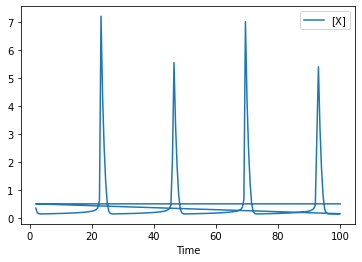

In [28]:
run_scan(output=['Time', '[X]']).plot(x='Time', y='[X]')